In [1]:
import pickle
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PKL_PATH = Path("data/RML2016.10a_dict.pkl")

with open(PKL_PATH, "rb") as f:
    d = pickle.load(f, encoding="latin1")

In [9]:
mods = sorted({k[0] for k in d.keys()})
snrs = sorted({k[1] for k in d.keys()})

print("Number of modulations:", len(mods))
print("Modulations:", mods)
print("Number of SNR levels:", len(snrs))
print("SNR range:", snrs[0], "to", snrs[-1])

print("Example shape:", d[(mods[0], snrs[0])].shape)

Number of modulations: 11
Modulations: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
Number of SNR levels: 20
SNR range: -20 to 18
Example shape: (1000, 2, 128)


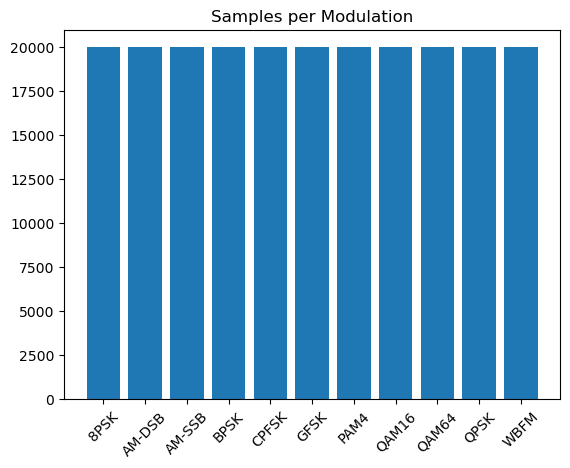

In [10]:
mod_counts = {mod: 0 for mod in mods}

for (mod, snr), arr in d.items():
    mod_counts[mod] += arr.shape[0]

plt.figure()
plt.bar(mod_counts.keys(), mod_counts.values())
plt.xticks(rotation=45)
plt.title("Samples per Modulation")
plt.show()

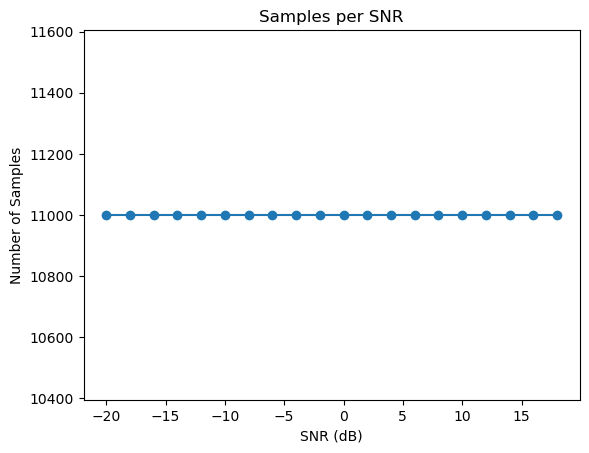

In [11]:
snr_counts = {snr: 0 for snr in snrs}

for (mod, snr), arr in d.items():
    snr_counts[snr] += arr.shape[0]

plt.figure()
plt.plot(list(snr_counts.keys()), list(snr_counts.values()), marker="o")
plt.title("Samples per SNR")
plt.xlabel("SNR (dB)")
plt.ylabel("Number of Samples")
plt.show()

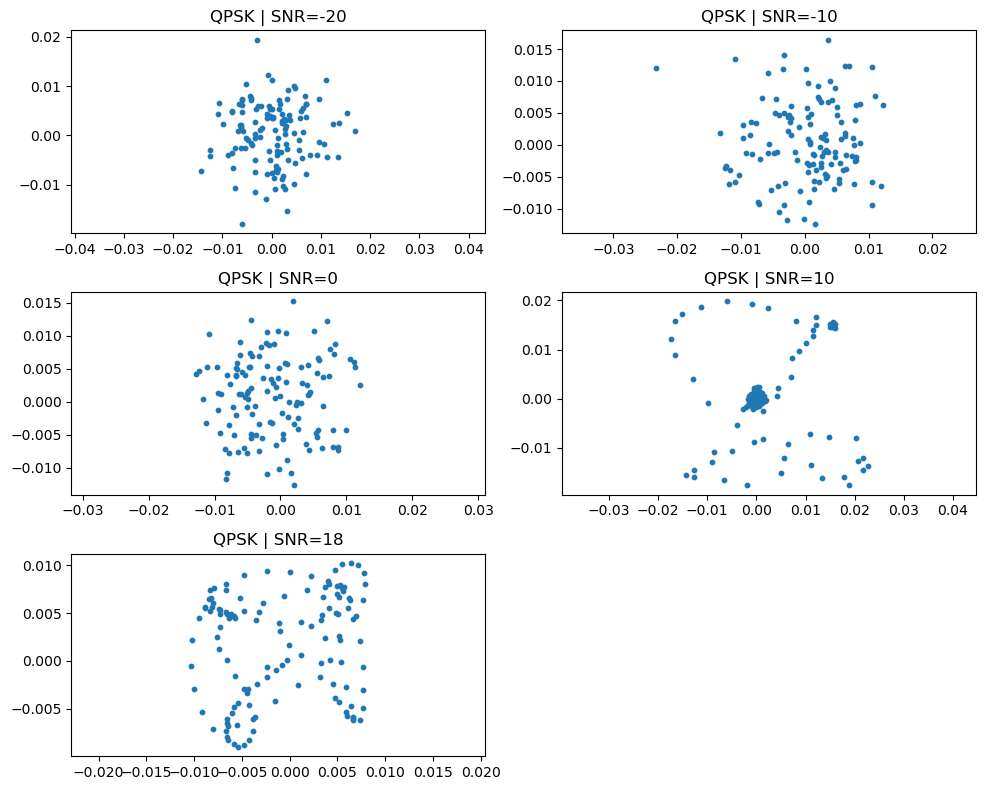

In [12]:
mod_demo = "QPSK" if "QPSK" in mods else mods[0]
snr_list = [-20, -10, 0, 10, 18]

plt.figure(figsize=(10,8))

for i, snr in enumerate(snr_list):
    if snr not in snrs:
        continue
        
    arr = d[(mod_demo, snr)]
    I = arr[0,0,:]
    Q = arr[0,1,:]
    
    plt.subplot(3,2,i+1)
    plt.scatter(I, Q, s=10)
    plt.title(f"{mod_demo} | SNR={snr}")
    plt.axis("equal")

plt.tight_layout()
plt.show()

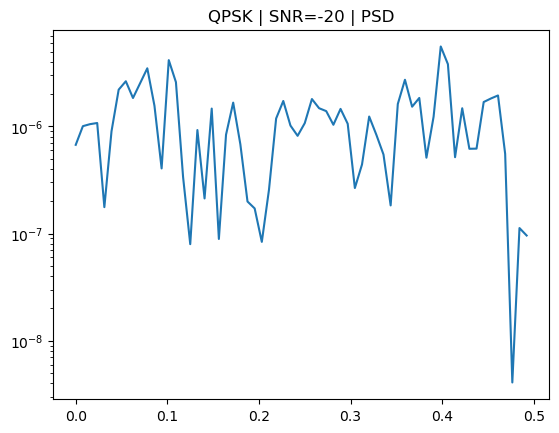

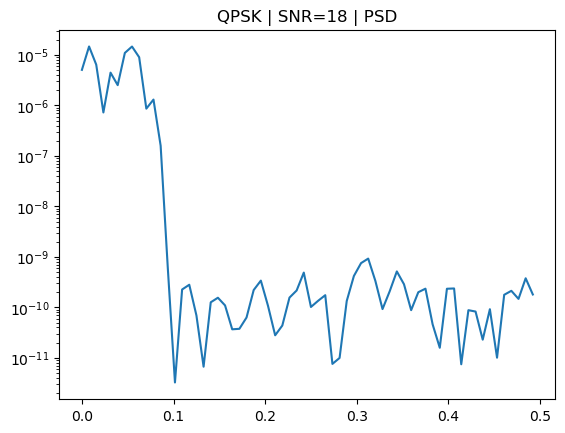

In [13]:
mod_demo = "QPSK" if "QPSK" in mods else mods[0]

for snr_demo in [-20, 18]:
    if snr_demo not in snrs:
        continue
        
    arr = d[(mod_demo, snr_demo)]
    I = arr[0,0,:]
    Q = arr[0,1,:]
    z = I + 1j*Q
    
    f, psd = complex_single_sided_psd(z)
    
    plt.figure()
    plt.semilogy(f, psd + 1e-12)
    plt.title(f"{mod_demo} | SNR={snr_demo} | PSD")
    plt.show()

In [19]:
import numpy as np

def complex_single_sided_psd(z, fs=1.0):
    z = np.asarray(z, dtype=np.complex128).ravel()
    N = z.size
    if N < 4:
        raise ValueError("Signal too short for PSD.")

    w = np.hanning(N)
    Zw = np.fft.fft(z * w)
    f = np.fft.fftfreq(N, d=1/fs)

    U = (w**2).sum() / N  # window power normalization
    psd_two = (np.abs(Zw)**2) / (fs * (N**2) * U + 1e-24)

    # keep non-negative freqs
    idx = f >= 0
    f_pos = f[idx]
    psd_pos = psd_two[idx].copy()

    # single-sided scaling (except DC and Nyquist)
    if N % 2 == 0 and psd_pos.size > 2:
        psd_pos[1:-1] *= 2
    elif N % 2 == 1 and psd_pos.size > 1:
        psd_pos[1:] *= 2

    return f_pos, psd_pos

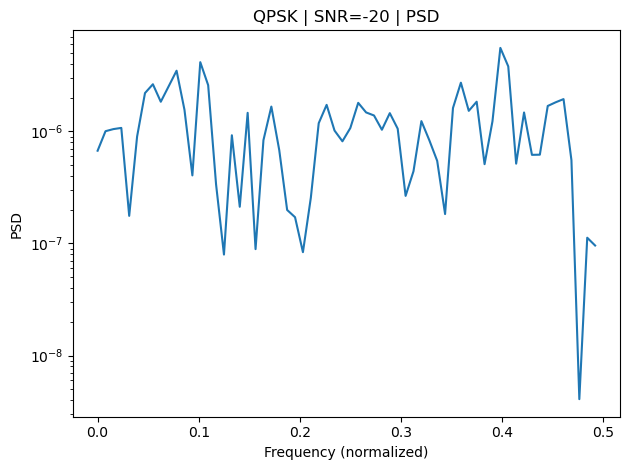

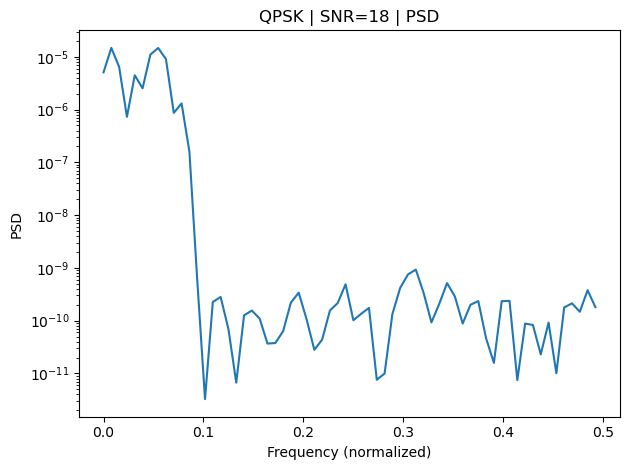

In [20]:
import matplotlib.pyplot as plt

mod_demo = "QPSK" if "QPSK" in mods else mods[0]

for snr_demo in [-20, 18]:
    if snr_demo not in snrs:
        continue
        
    arr = d[(mod_demo, snr_demo)]
    I = arr[0,0,:]
    Q = arr[0,1,:]
    z = I + 1j*Q
    
    f, psd = complex_single_sided_psd(z)
    
    plt.figure()
    plt.semilogy(f, psd + 1e-12)
    plt.title(f"{mod_demo} | SNR={snr_demo} | PSD")
    plt.xlabel("Frequency (normalized)")
    plt.ylabel("PSD")
    plt.tight_layout()
    plt.show()

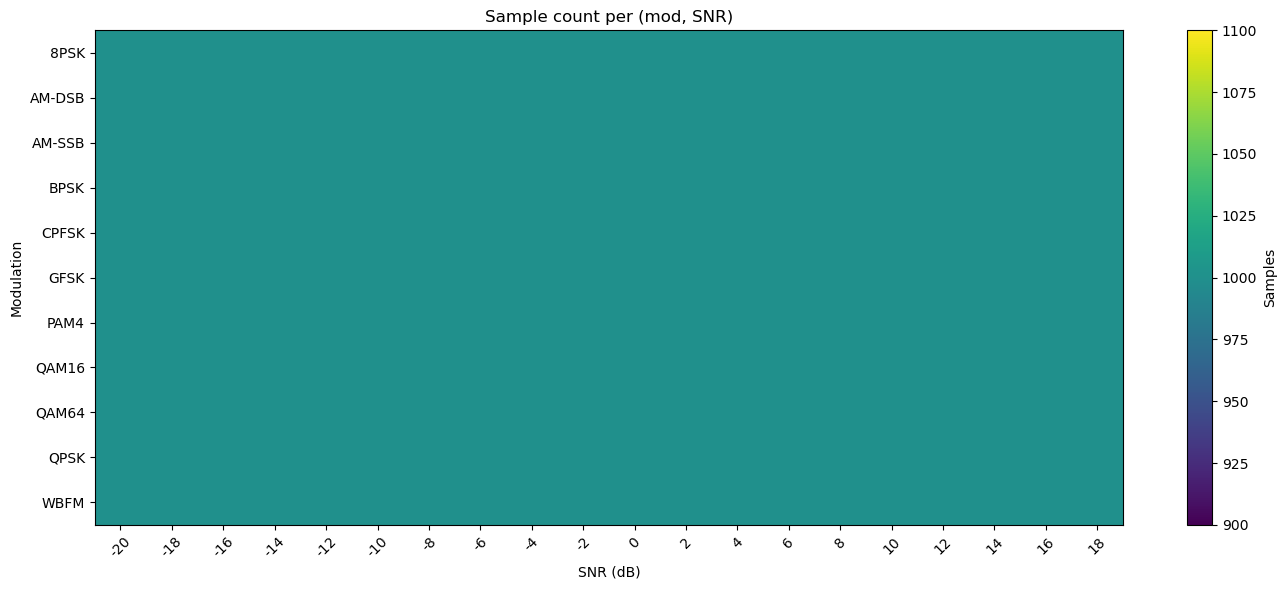

Total combos: 220 | Missing combos: 0
Min non-zero: 1000
Max: 1000


In [21]:
import pandas as pd
import matplotlib.pyplot as plt

count_rows = []
for m in mods:
    for s in snrs:
        arr = d.get((m, s), None)
        n = int(arr.shape[0]) if hasattr(arr, "shape") else 0
        count_rows.append({"mod": m, "snr": s, "count": n})

df_counts = pd.DataFrame(count_rows)
pivot = df_counts.pivot(index="mod", columns="snr", values="count").fillna(0).astype(int)

plt.figure(figsize=(14, 6))
plt.imshow(pivot.values, aspect="auto")
plt.colorbar(label="Samples")
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=45)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.xlabel("SNR (dB)")
plt.ylabel("Modulation")
plt.title("Sample count per (mod, SNR)")
plt.tight_layout()
plt.show()

missing = int((pivot == 0).sum().sum())
print("Total combos:", pivot.size, "| Missing combos:", missing)
print("Min non-zero:", int(pivot[pivot > 0].min().min()) if (pivot > 0).any().any() else None)
print("Max:", int(pivot.max().max()))

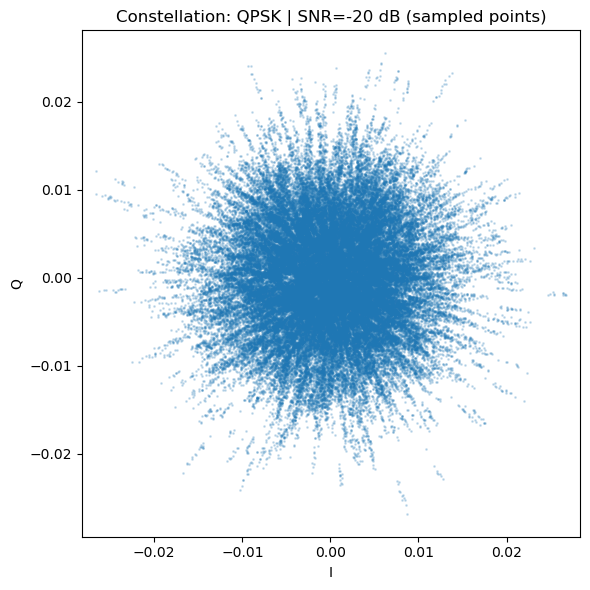

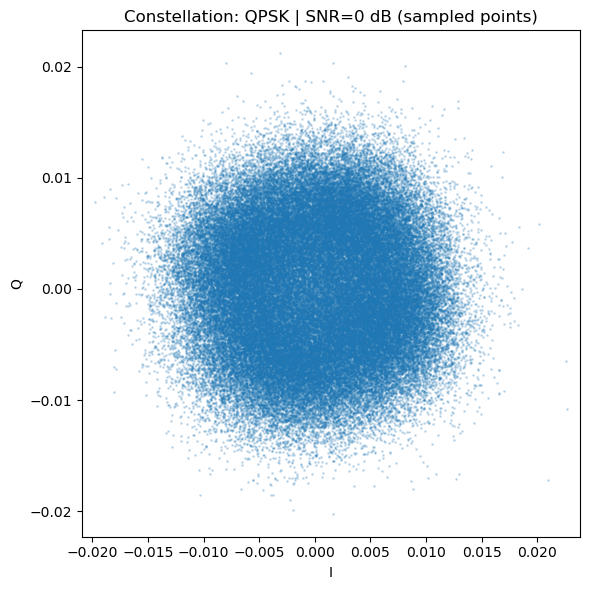

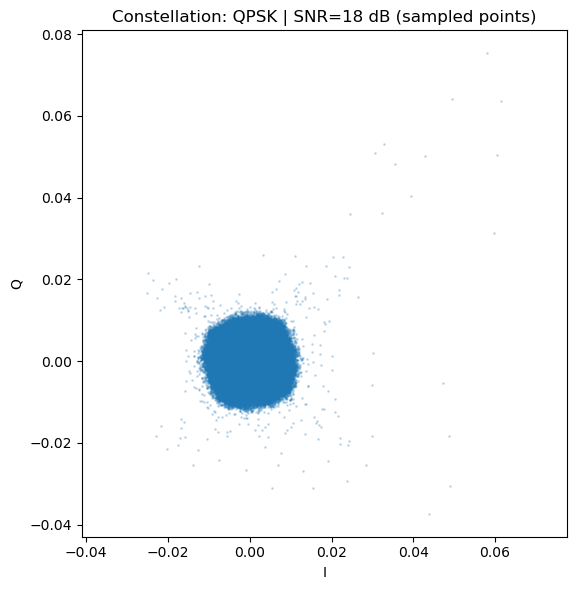

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def plot_constellation(mod, snr, max_points=100_000):
    arr = d[(mod, snr)]  # (N,2,128)
    z = arr[:,0,:] + 1j*arr[:,1,:]          # (N,128)
    x = np.real(z).ravel()
    y = np.imag(z).ravel()

    if x.size > max_points:
        idx = np.random.choice(x.size, size=max_points, replace=False)
        x, y = x[idx], y[idx]

    plt.figure(figsize=(6,6))
    plt.scatter(x, y, s=1, alpha=0.2)
    plt.title(f"Constellation: {mod} | SNR={snr} dB (sampled points)")
    plt.xlabel("I")
    plt.ylabel("Q")
    plt.axis("equal")
    plt.tight_layout()
    plt.show()

mod_demo = "QPSK" if "QPSK" in mods else mods[0]
for snr_demo in [-20, 0, 18]:
    if snr_demo in snrs:
        plot_constellation(mod_demo, snr_demo)

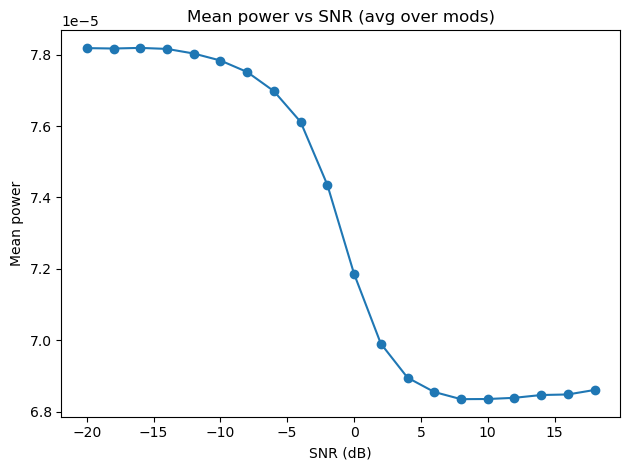

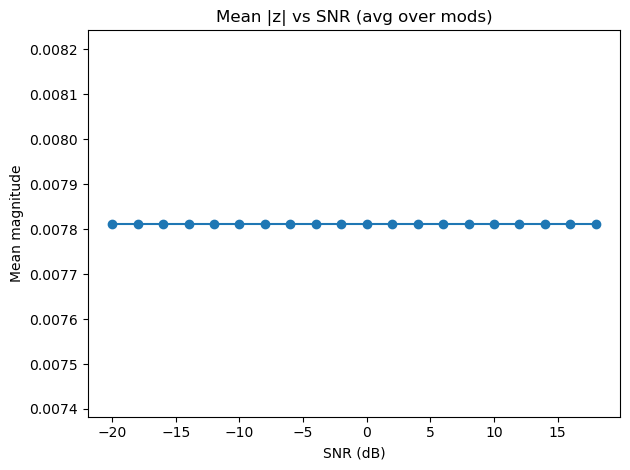

,mod,snr,N,mean_power,mean_mag,std_mag
0,QPSK,2,1000,0.000068,0.007812,0.002702
1,PAM4,8,1000,0.000082,0.007812,0.004537
2,AM-DSB,-4,1000,0.000076,0.007812,0.003885
3,GFSK,6,1000,0.000062,0.007812,0.000862
4,QAM64,8,1000,0.000072,0.007812,0.003301


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rows = []
for (m, s), arr in d.items():
    z = arr[:,0,:] + 1j*arr[:,1,:]
    p = np.abs(z)**2
    r = np.abs(z)
    rows.append({
        "mod": m, "snr": s, "N": int(arr.shape[0]),
        "mean_power": float(p.mean()),
        "mean_mag": float(r.mean()),
        "std_mag": float(r.std()),
    })

df = pd.DataFrame(rows)
snr_agg = df.groupby("snr")[["mean_power","mean_mag","std_mag"]].mean().reset_index().sort_values("snr")

plt.figure()
plt.plot(snr_agg["snr"], snr_agg["mean_power"], marker="o")
plt.title("Mean power vs SNR (avg over mods)")
plt.xlabel("SNR (dB)")
plt.ylabel("Mean power")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(snr_agg["snr"], snr_agg["mean_mag"], marker="o")
plt.title("Mean |z| vs SNR (avg over mods)")
plt.xlabel("SNR (dB)")
plt.ylabel("Mean magnitude")
plt.tight_layout()
plt.show()

df.head()